# Unsupervised GraphSAGE  - node classification
### Cora citation dataset

Stellargraph Unsupervised GraphSAGE is the reimplementation of GraphSAGE method outlined in the paper: ***[Inductive Representation Learning on Large Graphs.](http://snap.stanford.edu/graphsage/)*** W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216
[cs.SI], 2017. 

This notebook is a short demo of how Stellargraph Unsupervised GraphSAGE implementation can be used to learn embeddings of the nodes of the [CORA citation network](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz). Furthermore, this notebook demonstrates the efficay of the learnt embeddings in a downstream node classification task. Note that the node embeddings can also be used in other tasks, such as link prediction, community detection, among others.

### Unsupervised GraphSAGE:

A high-level explanation of the unsupervised GraphSAGE method is as follows.

***Given a graph, learn embeddings of the nodes using only the graph structure and the node features without any known class labels.***

**Unsupervised GraphSAGE model:** In the Unsupervised GraphSAGE model, the embeddings are learnt by feeding it a training sample of (target, context) node pairs that reflect potential positive and negative links between them in a given context, such as, whether they co-occur in relatively short random walks over the graph. The graphSAGE method then learns the embeddings of the nodes by aggregating feature information of the (target, context) nodes' neighborhood. 
In this implementation of Unsupervised GraphSAGE, the training set provided to the GraphSAGE method is composed of an equal number of positive and negative (target, context) pairs from the graph. The positive (target, context) pairs are the node pairs co-occuring on random walks  over the graph whereas the negative (target, context) pairs are sampled from a global node distribution. Note that since this is unsupervised learning task, these positive and negative pairs are extracted without any true node label information fed to the GraphSAGE model. 

Given this training set, the Unsupervised GraphSAGE model learns the embeddings for the each target and each context by node neighborhood feature aggregation. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. 

The obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. 
The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model that are generated on demand.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

import keras 
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score


from stellargraph import globalvar

Using TensorFlow backend.


### Loading the CORA network data

The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = "~/data/cora"

Load the graph from edgelist.

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"  # set the edge type

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

Specify the node types.

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes.

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

The node features are all attributes except the paper subject (we will use this for plotting the embeddings later). Paper subject label are not used for unsupervised trainning.

In [7]:
node_features = node_data[feature_names]

### Unsupervised GraphSAGE  with on demand sampling
The unsupervised graphSAGE requires a training sample that can be either provided as a list of (target, context) pairs or it can be provided with an `UnsupervisedSampler` instance that takes care of generating the training samples on demand. In this demo we discuss the later technique. 

#### UnsupervisedSampler:
Given a graph and a walker the `UnsupervisedSampler` is responsible for generating a batch-size of +/- samples on demand. Given a `Stellargraph` graph instance, the UnsupervisedSampler is responsible for generatating a `batch_size` number of positive and negative samples extracted from Uniform Random walks over the graph. In the current implementation, the walks are fixed to be uniform random, however, the length and number of walks as well as the root nodes for starting the walks can be user specified. Note that the default values for root nodes is all nodes of the graph, number of walks is 1, and length of walks is 2 (need at least one node beyond the root/target node on the walk as a potential positive context). 
 
**(Sample) Generator:**

The generator method in the UnsupervisedSampler class is responsible for generating training samples for unsupervised learning, *given, a stellargraph and batch size*. The batch_size is mendatory as without it, the generator doesn't know how many samples are to be returned. 

In this version, the batch_size has to be  positive even number. Restriction of a positive number is self-evident, the even limitation is because the sample returned has equal number of positive and negative samples. There are other obvious alternatives, such as, returning one more or less negative sample or taking in number of positive and nagative samples per batch as two separate user specified parameters, among other ideas. 

**GraphSAGE style sampling:**

The generator method calls the UniformRandomWalker to perform one walk at a time starting from each root node. From each walk, (target, context) pairs are sampled such that the root node is always the target and all the nodes encountered in the current  walk, are the positive contexts, except for the target itself. 

For each positive context, a negative context is sampled randomly from the degree ditribution of the graph, *regardless of whether the negative sample is the target itself or one of the contexts in the current walk*.

Once the batch_size size of samples are accumulated, the generator returns, the list of positive and negative pairs along with their respective +/- labels.  

**1. Create the Stellargraph with node features.**

In [8]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [9]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



**3. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, random seed.**

In [10]:
nodes = G.nodes()
number_of_walks = 1
length = 5

**4. Create the UnsupervisedSampler instance with the relevant parameters passed to it.**

In [11]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks)

#unsupervisedSamples = UnsupervisedSampler(G, nodes = nodes,length = length, number_of_walks = number_of_walks )

The graph G together with the unsupervised sampler will be used to generate samples.

**5. Create a link mapper:**

Next, create the link mapper for sampling and streaming the training data to the model. The link mapper essentially "map" pairs of nodes `(target, context)` to the input of GraphSAGE: it either take minibatches of node pairs, or an UnsupervisedSampler instance which generates the minibatches of node pair on demand. The mapper samples 2-hop subgraphs with `(target, context)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent positive and negative pairs, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify:
1. The minibatch size (number of node pairs per minibatch).
2. The number of epochs for training the model.
3. The sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [18]:
batch_size = 50
epochs = 4
num_samples = [10, 5]

In the following we show the working of link mapper with the UnsupervisedSampler which will generate samples on demand.

In [19]:
train_gen = GraphSAGELinkGenerator(G, batch_size, num_samples).flow(unsupervised_samples)

Running GraphSAGELinkGenerator with an estimated 542 batches generated on the fly per epoch.


Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(node1, node2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1).
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [20]:
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.0, normalize="l2"
    )

In [21]:
# Expose input and output sockets of graphsage, for source and destination nodes:
x_inp_src, x_out_src = graphsage.default_model(flatten_output=False)
x_inp_dst, x_out_dst = graphsage.default_model(flatten_output=False)
# re-pack into a list where (source, destination) inputs alternate, for link inputs:
x_inp = [x for ab in zip(x_inp_src, x_inp_dst) for x in ab]
# same for outputs:
x_out = [x_out_src, x_out_dst]

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [22]:
prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [23]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

**6. Train the model.**

In [24]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        verbose=1,
        use_multiprocessing=False,
        workers=0,
        shuffle=True,
    )

Epoch 1/4
542/542 [==============================] - 72s 133ms/step - loss: 0.5681 - binary_accuracy: 0.7457
Epoch 2/4
542/542 [==============================] - 72s 132ms/step - loss: 0.5439 - binary_accuracy: 0.7743
Epoch 3/4
542/542 [==============================] - 72s 133ms/step - loss: 0.5393 - binary_accuracy: 0.7866
Epoch 4/4
542/542 [==============================] - 72s 133ms/step - loss: 0.5379 - binary_accuracy: 0.7897


Note that multiprocessing is switched off but it works. However, with a large training set, multiprocessing can considerably slow down the training process with the data being transferred between various processors. 
Also, multiple workers can be used with `Keras version 2.2.4` and it speeds up the training process considerably. However, the multithreading behavior is unpredicatable due to locking enabled on the generator when multiple threads are using the same instance of the UnsupervisedSampler for "on demand" sampling.

### Extracting node embeddings

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

We use another Keras model to extract the embeddings for all the nodes.

In [26]:
node_ids = node_data.index

**Building a new node-based model**

A node-based embedding model made by creating another graphsage model with the same parameters and settng the weights of the trained model.

In [27]:
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [28]:
graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=node_gen, bias=True, dropout=0.0, normalize="l2"
    )
x_inp_emb, x_out_emb = graphsage.default_model(flatten_output=False)
embedding_model = keras.Model(inputs=x_inp_emb, outputs=x_out_emb)

In [29]:
embedding_model.set_weights(model.get_weights())

We now get a new Node Generator and feed all nodes into it.

In [30]:
emb = embedding_model.predict_generator(node_gen, workers=4, verbose=1)
node_embeddings = emb[:,0,:]

55/55 [==============================] - 1s 20ms/step


In [31]:
node_subject = node_data["subject"].astype('category').cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed['label'] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] =  node_subject

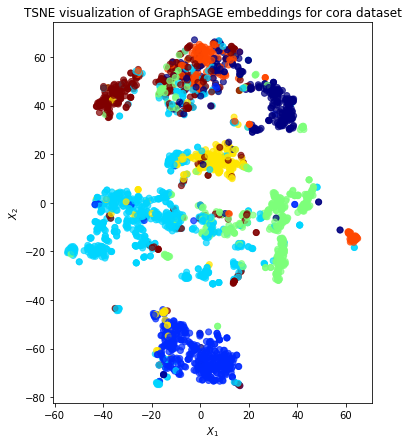

In [32]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()

### Downstream task

The node embeddings calculated using the unsupervised GraphSAGE can be used as feature vectors in a downstream task such as node classification. 

In this example, we will use the  node embeddings to train a classifier to predict the subject of a paper in Cora.

In [33]:
# X will hold the 50 input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_subject)

### Data Splitting

We split the data into train and test sets. 

We use 20% of the data for training and the remaining 80% for testing as a hold out test set.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.20, test_size=None)

### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [35]:
clf = LogisticRegression(verbose=3)
clf.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=3, warm_start=False)

Predict the hold out test set.

In [36]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [37]:
accuracy_score(y_test, y_pred)

0.7660359944623903

**Predicted classes**

In [38]:
pd.Series(y_pred).value_counts()

2    633
1    388
6    369
3    302
0    211
4    175
5     89
dtype: int64

**True classes**

In [39]:
pd.Series(y).value_counts()

2    818
3    426
1    418
6    351
0    298
4    217
5    180
dtype: int64

### Uses for unsupervised embeddings
1. Unsupervised GraphSAGE learns embedding of unlabeled graph data. This is highly useful as most of the real world data is typically either unlabeled or the labeled in not very objective way. In such scenrios unsupervised techniques that learn low-dimensional meaningful representation of nodes in a graph by leveraging the graph structure and features of the nodes is neat.
2. Moreover, graphSAGE is an inductive technique that efficiently learns embeddings of unseen data. That is, instead of training individual embeddings for each node, we learn a function that generates embeddings by sampling and aggregating features from nodes' local neighborhood.